In [1]:
import os
import csv
import argparse
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from dataset import SiameseNetworkDataset
from model import SiameseNetwork

from sklearn import metrics
import Utils

### Load Trained CKPT

In [2]:
model = SiameseNetwork(network="ResNet-50", in_channels=3, n_features=128).to('cuda')

# Loading ckpt
# CKPT_PATH = "trained_models/best_network.pth"
CKPT_PATH = "/raid/s2198939/diffusion_memorization/PatientVerification/checkpoints/ResNet-50_epoch1_data_handling_RPN.pth"
model.load_state_dict(torch.load(CKPT_PATH))
model.eval()

/raid/s2198939/miniconda3/envs/demm/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/raid/s2198939/miniconda3/envs/demm/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_3891977/3274070059.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch

SiameseNetwork(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
     

### Prepare Data

In [3]:
CSV_DIR = "/raid/s2198939/MIMIC_Dataset/physionet.org/files/mimic-cxr-jpg/2.0.0/Prepared_CSV2"
IMG_DIR = "/raid/s2198939/MIMIC_Dataset/physionet.org/files/mimic-cxr-jpg/2.0.0"
test_csv = os.path.join(CSV_DIR, "FINAL_TEST.xlsx")

df_test = pd.read_excel(test_csv)
df_test["path"] = df_test["path"].apply(lambda x: os.path.join(IMG_DIR, x))

len(df_test)

14065

In [4]:
image_data = list(zip(df_test['path'], df_test['subject_id']))

# Define any transformations (e.g., resizing, normalization).
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create the dataset and dataloader.
dataset = SiameseNetworkDataset(image_data, transform=transform, data_handling='RPN')
dataloader = DataLoader(dataset, shuffle=True, batch_size=2)

## Running Eval

In [6]:
# From: https://github.com/SANCHES-Pedro/privacy_diffusion_medical/blob/557d7372992e8f13a8f564b5739ade53a7d7c551/eval/quantitative/PatientVerification/utils/Utils.py#L143

def test(model, dataloader):
    y_true = None
    y_pred = None

    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            inputs1, inputs2, labels = batch
            inputs1 = inputs1.to('cuda')
            inputs2 = inputs2.to('cuda')
            labels = labels.to('cuda')

            if y_true is None:
                y_true = labels
            else:
                y_true = torch.cat((y_true, labels), 0)

            outputs = model(inputs1, inputs2)
            outputs = torch.sigmoid(outputs)
            
            if y_pred is None:
                y_pred = outputs.cpu()
            else:
                y_pred = torch.cat((y_pred, outputs.cpu()), 0)

    y_pred = y_pred.squeeze()
    return y_true, y_pred
            

In [7]:
y_true, y_pred = test(model, dataloader)

In [8]:
y_true, y_pred = [y_true.cpu().numpy(), y_pred.cpu().numpy()]

In [9]:
fp_rates, tp_rates, thresholds = metrics.roc_curve(y_true, y_pred)
auc = metrics.roc_auc_score(y_true, y_pred)
y_pred_thresh = Utils.apply_threshold(y_pred, 0.5)
accuracy, f1_score, precision, recall, report, confusion_matrix = Utils.get_evaluation_metrics(y_true,
                                                                                                y_pred_thresh)

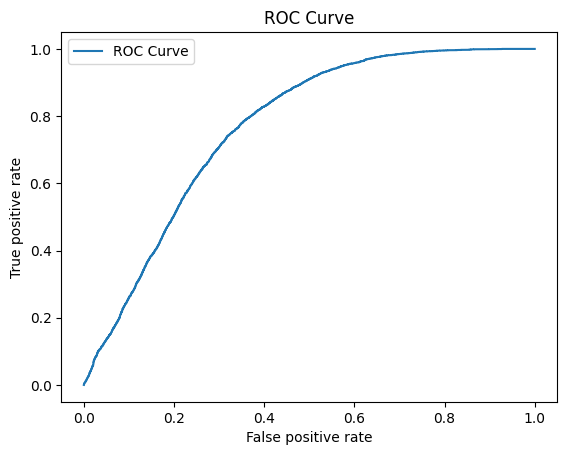

In [10]:
Utils.plot_roc_curve(fp_rates, tp_rates, "RESULTS", "MIMIC_EVAL")

In [11]:
auc_mean, confidence_lower, confidence_upper = Utils.bootstrap(10000,
                                                                y_true,
                                                                y_pred,
                                                                "RESULTS/",
                                                                "MIMIC_EVAL")

FileNotFoundError: [Errno 2] No such file or directory: 'RESULTS/MIMIC_EVAL_AUC_bootstrapped.txt'

In [ ]:
print('EVALUATION METRICS:')
print('AUC: ' + str(auc))
print('Accuracy: ' + str(accuracy))
print('F1-Score: ' + str(f1_score))
print('Precision: ' + str(precision))
print('Recall: ' + str(recall))
print('Report: ' + str(report))
print('Confusion matrix: ' + str(confusion_matrix))

print('BOOTSTRAPPING: ')
print('AUC Mean: ' + str(auc_mean))
print('Confidence interval for the AUC score: ' + str(confidence_lower) + ' - ' + str(confidence_upper))